<a href="https://colab.research.google.com/github/youssef1232004/Soft_Computing./blob/main/Copy_of_Final_Soft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Required Libraries**

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import warnings
from sklearn.ensemble import RandomForestClassifier

# **Load CSV**

In [101]:
data = pd.read_csv("/content/spambase.csv")

# **Data Overview**

In [102]:
print("Data Overview:")
print(f"Shape: {data.shape}")
print("\nFirst 5 Rows:")
print(data.head())
print("\nData Types:")
print(data.dtypes.value_counts())
print("\nMissing Values:")
print(data.isnull().sum())

Data Overview:
Shape: (4601, 58)

First 5 Rows:
   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00     

# **Count of Spam vs. Not**

In [103]:
print(data['spam'].value_counts())

spam
0    2788
1    1813
Name: count, dtype: int64


# **Splitting Features and Target**

In [104]:
# Separate features and target variable
X = data.drop('spam', axis=1)
y = data['spam']

# **List of Features**

In [105]:
print(X.columns)
print(X.dtypes.value_counts())


Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


In [106]:

# Compute Mutual Information
mutual_inf = mutual_info_classif(X, y)
feature_importance = pd.DataFrame({'Mutual Inf': mutual_inf}, index=X.columns)
sorted_feature_importance = feature_importance.sort_values(by='Mutual Inf', ascending=False)

# Compute the correlation matrix
corr_matrix = X.corr().abs()

# Create an upper triangle correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize set of features to drop
to_drop = set()

# Iterate over correlated pairs and drop lower-importance feature
for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > 0.9:
            if row in to_drop or col in to_drop:
                continue
            # Compare Mutual Info and keep more important one
            if feature_importance.loc[row, 'Mutual Inf'] < feature_importance.loc[col, 'Mutual Inf']:
                to_drop.add(row)
            else:
                to_drop.add(col)

# Drop features from the original dataset
X_reduced = X.drop(columns=list(to_drop))

print("Dropped features due to high correlation:", to_drop)
print("Remaining features:", X_reduced.shape[1])


Dropped features due to high correlation: {'word_freq_415'}
Remaining features: 56


# **Splitting Data into Train/Test (80/20)**

In [107]:
SEED = 30
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size = 0.2, shuffle = True, random_state = SEED)

print('train samples: ', X_train.shape)
print('test samples: ', X_test.shape)

train samples:  (3680, 56)
test samples:  (921, 56)


# **Feature Normalization**

In [108]:
# Scaling numerical data
MM = MinMaxScaler()
MM_fit = MM.fit(X_train)
X_train = MM_fit.transform(X_train)
X_test = MM_fit.transform(X_test)


# **Define Evaluation Metrics & Models**

In [109]:
# Evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }


# Define classifiers
models = {
    "SVM": SVC(kernel='linear', C=1),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}



# **Model Evaluation with All Features**

In [111]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model on training data
    model.fit(X_train, y_train)
    # Predict labels for test data
    y_pred = model.predict(X_test)

    # Compute weighted average of evaluation metrics (suitable for multiclass)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-score': f1_score(y_test, y_pred, average='weighted')
    }

# Print header for clarity
print(" Performance for All Features")

# Evaluate all models and store results in a dictionary
results_all = {name: evaluate_model(model, X_train, X_test, y_train, y_test) for name, model in models.items()}

# Convert the dictionary of results to a pandas DataFrame and transpose for readability
all_results_df = pd.DataFrame(results_all).T

# Display the evaluation metrics for each model
print(all_results_df)


 Performance for All Features
               Accuracy  Precision    Recall  F1-score
SVM            0.895765   0.896750  0.895765  0.894194
KNN            0.878393   0.877712  0.878393  0.877514
Random Forest  0.934853   0.934869  0.934853  0.934475


# **Detailed Model Evaluation & Confusion Matrix Visualization**


Evaluating SVM using all features
Accuracy Score: 89.58 %

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       578
           1       0.91      0.80      0.85       343

    accuracy                           0.90       921
   macro avg       0.90      0.88      0.89       921
weighted avg       0.90      0.90      0.89       921



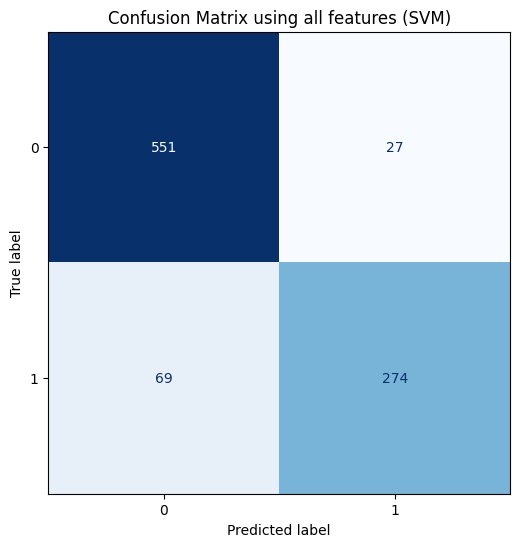


Evaluating KNN using all features
Accuracy Score: 87.84 %

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       578
           1       0.86      0.80      0.83       343

    accuracy                           0.88       921
   macro avg       0.87      0.86      0.87       921
weighted avg       0.88      0.88      0.88       921



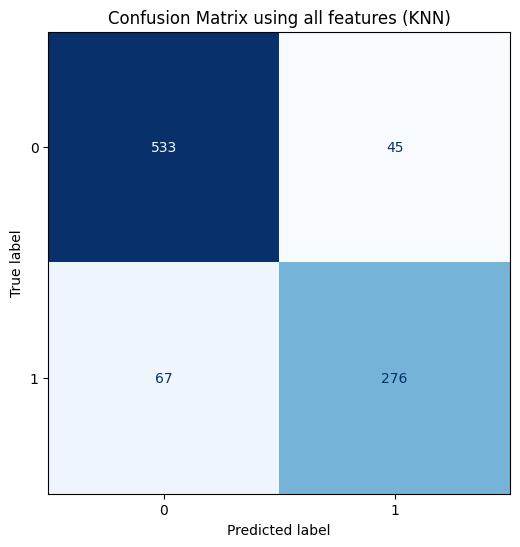


Evaluating Random Forest using all features
Accuracy Score: 93.49 %

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       578
           1       0.94      0.89      0.91       343

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.93       921
weighted avg       0.93      0.93      0.93       921



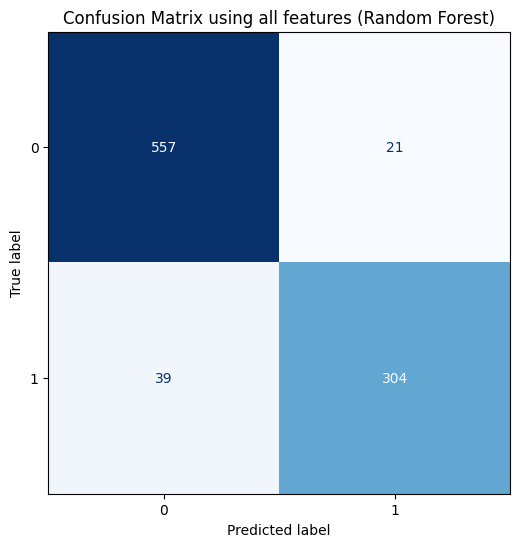

In [130]:
# Get unique class labels from the combined train and test sets (supports multiclass)
unique_classes = np.unique(np.concatenate([y_train, y_test]))
# Convert class labels to strings for display or replace with class names if available
class_names = [str(c) for c in unique_classes]

for name, model in models.items():
    print(f"\n{'='*30}\nEvaluating {name} using all features\n{'='*30}")

    # Train the model on training data
    model.fit(X_train, y_train)
    # Predict labels on test data
    y_pred = model.predict(X_test)

    # Calculate and print accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score: {acc * 100:.2f} %")

    # Print a detailed classification report with precision, recall, f1-score per class
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Generate confusion matrix and plot it
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix using a blue-purple colormap, no colorbar for simplicity
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix using all features ({name})")
    plt.show()


## **GA**

# **GA Hyperparameters Setup**

In [112]:
# Define Genetic Algorithm (GA) hyperparameters

size = 100             # Population size (number of candidate solutions per generation)
n_feat = X_train.shape[1]  # Number of features in the dataset
n_parents = 50         # Number of top parents selected for mating in each generation
mutation_rate = 0.1    # Probability of mutation applied to offspring
n_gen = 30             # Number of generations to run the GA


# **Initialize GA Population**

In [113]:
# Function to initialize the GA population
def initialization_of_population(size, n_feat):
    population = []
    for i in range(size):
        # Create a chromosome with all features initially selected (True)
        chromosome = np.ones(n_feat, dtype=bool)
        # Set approximately 30% of features to False (not selected)
        chromosome[:int(0.3 * n_feat)] = False
        # Shuffle to randomize feature selection pattern in chromosome
        np.random.shuffle(chromosome)
        # Add the chromosome to the population
        population.append(chromosome)
    return population


# **Fitness Score Calculation for GA Population**

In [114]:
def fitness_score(population):
    scores = []
    for chromosome in population:
        # Train the model using only the selected features
        model.fit(X_train[:, chromosome], y_train)
        # Predict on test set with selected features
        predictions = model.predict(X_test[:, chromosome])
        # Calculate accuracy and append to scores list
        scores.append(accuracy_score(y_test, predictions))

    # Convert scores and population to numpy arrays for sorting
    scores, population = np.array(scores), np.array(population)

    # Get indices that would sort scores ascending
    inds = np.argsort(scores)

    # Return scores and population sorted descending by accuracy (best first)
    return list(scores[inds][::-1]), list(population[inds, :][::-1])


# **Parent Selection in Genetic Algorithm**

In [115]:
# Function to select top parents for next generation
def selection(pop_after_fit, n_parents):
    population_nextgen = []
    # Select the top 'n_parents' chromosomes from the sorted population
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


# **Crossover in Genetic Algorithm**

In [116]:
def crossover(pop_after_sel):
    # Start with the selected parents as the initial next generation
    pop_nextgen = pop_after_sel.copy()  # use copy() to avoid modifying original list

    # Loop over pairs of parents (step by 2)
    for i in range(0, len(pop_after_sel) - 1, 2):  # ensure i+1 is valid index
        child_1, child_2 = pop_after_sel[i], pop_after_sel[i + 1]
        # Create a new child by combining first half of parent1 and second half of parent2
        new_par = np.concatenate((child_1[:len(child_1) // 2], child_2[len(child_2) // 2:]))
        # Add new child to the next generation population
        pop_nextgen.append(new_par)

    return pop_nextgen


# **Mutation in Genetic Algorithm**

In [117]:
def mutation(pop_after_cross, mutation_rate, n_feat):
    # Calculate how many genes (features) to mutate per chromosome
    mutation_range = int(mutation_rate * n_feat)
    pop_next_gen = []

    # Iterate over each chromosome in the population
    for n in range(len(pop_after_cross)):
        chromo = pop_after_cross[n].copy()  # Copy to avoid modifying original directly

        rand_posi = []
        # Select random positions to mutate
        for i in range(mutation_range):
            pos = np.random.randint(0, n_feat)  # inclusive 0, exclusive n_feat
            rand_posi.append(pos)

        # Flip the bits (True → False, False → True) at selected positions
        for j in rand_posi:
            chromo[j] = not chromo[j]

        # Append mutated chromosome to new population list
        pop_next_gen.append(chromo)

    return pop_next_gen


# **Genetic Algorithm Generations Loop**

In [118]:
def generations(size, n_feat, n_parents, mutation_rate, n_gen, X_train, X_test, y_train, y_test):
    best_chromo = []  # To store best chromosome of each generation
    best_score = []   # To store best fitness score of each generation

    # Initialize population with random chromosomes
    population_nextgen = initialization_of_population(size, n_feat)

    for i in range(n_gen):
        # Calculate fitness scores and sort population by fitness
        scores, pop_after_fit = fitness_score(population_nextgen)

        # Print the best score of current generation (top score)
        print('Best score in generation', i + 1, ':', scores[0])

        # Select top parents based on fitness
        pop_after_sel = selection(pop_after_fit, n_parents)

        # Perform crossover to create offspring
        pop_after_cross = crossover(pop_after_sel)

        # Apply mutation to offspring to maintain diversity
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)

        # Save best chromosome and its score for this generation
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])

    return best_chromo, best_score


# **Genetic Algorithm with Optimized Hyperparameters**

In [119]:
# Run the GA using defined hyperparameters and training/testing data
best_chromo, best_score = generations(size, n_feat, n_parents, mutation_rate, n_gen,
                                      X_train, X_test, y_train, y_test)


Best score in generation 1 : 0.9446254071661238
Best score in generation 2 : 0.9457111834961998
Best score in generation 3 : 0.9457111834961998
Best score in generation 4 : 0.9500542888165038
Best score in generation 5 : 0.9500542888165038
Best score in generation 6 : 0.9446254071661238
Best score in generation 7 : 0.9446254071661238
Best score in generation 8 : 0.9467969598262758
Best score in generation 9 : 0.9457111834961998
Best score in generation 10 : 0.9467969598262758
Best score in generation 11 : 0.9478827361563518
Best score in generation 12 : 0.9446254071661238
Best score in generation 13 : 0.9511400651465798
Best score in generation 14 : 0.9446254071661238
Best score in generation 15 : 0.9457111834961998
Best score in generation 16 : 0.9457111834961998
Best score in generation 17 : 0.9489685124864278
Best score in generation 18 : 0.9489685124864278
Best score in generation 19 : 0.9457111834961998
Best score in generation 20 : 0.9478827361563518
Best score in generation 21 :

# **Display Best Feature Subset Selected by GA**

In [121]:
# Get the best chromosome from the last generation (best solution)
best_chromosome = best_chromo[-1]

# Filter original feature names using the boolean mask (chromosome)
selected_features = X_reduced.columns[best_chromosome]

# Print the number of features selected by the GA
print(f"Number of selected features: {len(selected_features)}")

# Print the names of the selected features
print("Best features selected by GA:")
print(selected_features)


Number of selected features: 31
Best features selected by GA:
Index(['word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_addresses',
       'word_freq_free', 'word_freq_business', 'word_freq_email',
       'word_freq_you', 'word_freq_000', 'word_freq_money', 'word_freq_hp',
       'word_freq_george', 'word_freq_650', 'word_freq_lab',
       'word_freq_telnet', 'word_freq_data', 'word_freq_85', 'word_freq_pm',
       'word_freq_meeting', 'word_freq_original', 'word_freq_project',
       'word_freq_re', 'word_freq_edu', 'char_freq_(', 'char_freq_$',
       'char_freq_#', 'capital_run_length_average',
       'capital_run_length_longest'],
      dtype='object')


# **Prepare Data with GA-Selected Features**


Evaluating SVM using GA-selected features
Accuracy Score: 85.23 %

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.83      0.96      0.89       578
        Spam       0.90      0.68      0.77       343

    accuracy                           0.85       921
   macro avg       0.87      0.82      0.83       921
weighted avg       0.86      0.85      0.85       921



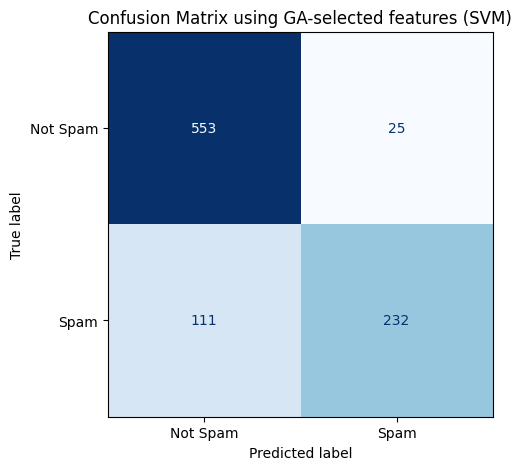


Evaluating KNN using GA-selected features
Accuracy Score: 87.84 %

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.90      0.91      0.90       578
        Spam       0.84      0.83      0.84       343

    accuracy                           0.88       921
   macro avg       0.87      0.87      0.87       921
weighted avg       0.88      0.88      0.88       921



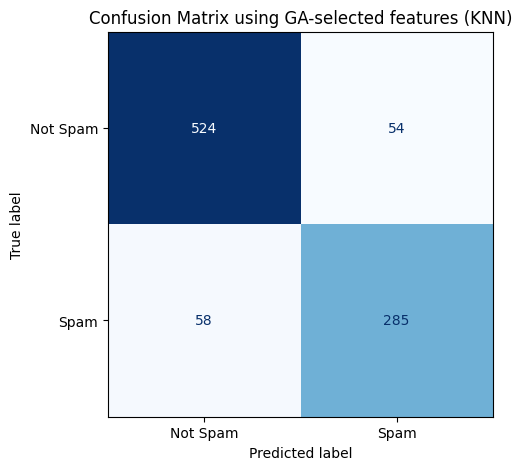


Evaluating Random Forest using GA-selected features
Accuracy Score: 95.01 %

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.95      0.97      0.96       578
        Spam       0.95      0.92      0.93       343

    accuracy                           0.95       921
   macro avg       0.95      0.94      0.95       921
weighted avg       0.95      0.95      0.95       921



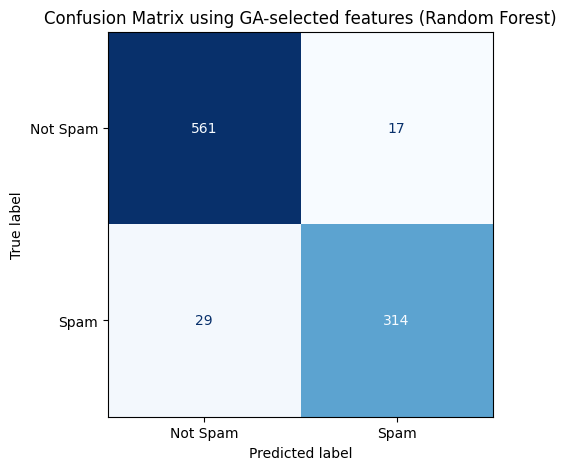

In [133]:
# Define class names
classes = {0: 'Not Spam', 1: 'Spam'}

# Evaluate and visualize results for all models
for name, model in models.items():
    print(f"\n{'='*30}\nEvaluating {name} using GA-selected features\n{'='*30}")

    # Train and predict
    model.fit(X_train_ga, y_train)
    y_pred = model.predict(X_test_ga)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score: {acc * 100:.2f} %")

    print("\nClassification Report:")
    # Use the defined 'classes' dictionary to get target names
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # Use the defined 'classes' dictionary to get display labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))

    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix using GA-selected features ({name})")
    plt.show()

In [129]:
# Select only the best features from training and testing data based on GA chromosome
X_train_ga = X_train[:, best_chromosome]
X_test_ga = X_test[:, best_chromosome]


# **Model Evaluation with GA-Selected Features**

## **PSO**

# **PSO Feature Selection**

In [124]:
# PSO hyperparameters
n_particles = 30       #particles in swarm
n_iterations = 50      # Number of iterations
n_features = X_train.shape[1]  # Number of features

w = 0.5                # Inertia weight
c1 = 1.5               # Cognitive component
c2 = 1.5               # Social component

# Set random seed for reproducibility
np.random.seed(SEED)

# Initialize particles (feature subsets) and their velocities with random values between 0 and 1
particles = np.random.rand(n_particles, n_features)
velocities = np.random.rand(n_particles, n_features)

# Initialize personal best positions and corresponding scores (accuracy)
personal_best_positions = particles.copy()
personal_best_scores = np.zeros(n_particles)

# Evaluate initial particles' fitness (accuracy on validation set)
for i in range(n_particles):
    selected = particles[i] > 0.5  # Binary mask: select features where value > 0.5

    # Avoid empty feature subset
    if np.sum(selected) == 0:
        personal_best_scores[i] = 0
    else:
        model.fit(X_train[:, selected], y_train)
        preds = model.predict(X_test[:, selected])
        personal_best_scores[i] = accuracy_score(y_test, preds)

# Identify the global best particle (highest accuracy)
global_best_idx = np.argmax(personal_best_scores)
global_best_position = personal_best_positions[global_best_idx].copy()

# PSO main optimization loop
for iteration in range(n_iterations):
    for i in range(n_particles):
        # Random factors for stochastic velocity update
        r1 = np.random.rand(n_features)
        r2 = np.random.rand(n_features)

        # Velocity update formula combines inertia, cognitive, and social components
        velocities[i] = (
            w * velocities[i]
            + c1 * r1 * (personal_best_positions[i] - particles[i])
            + c2 * r2 * (global_best_position - particles[i])
        )

        # Update particle position and keep values in [0, 1]
        particles[i] += velocities[i]
        particles[i] = np.clip(particles[i], 0, 1)

        # Evaluate fitness of new position
        selected = particles[i] > 0.5
        if np.sum(selected) == 0:
            score = 0
        else:
            model = SVC(kernel='linear', random_state=SEED)
            model.fit(X_train[:, selected], y_train)
            preds = model.predict(X_test[:, selected])
            score = accuracy_score(y_test, preds)

        # Update personal best if new score is better
        if score > personal_best_scores[i]:
            personal_best_scores[i] = score
            personal_best_positions[i] = particles[i].copy()

    # Update global best based on all personal bests
    global_best_idx = np.argmax(personal_best_scores)
    global_best_position = personal_best_positions[global_best_idx].copy()

    print(f"Iteration {iteration + 1}/{n_iterations}, Best Accuracy: {personal_best_scores[global_best_idx]:.4f}")


Iteration 1/50, Best Accuracy: 0.9414
Iteration 2/50, Best Accuracy: 0.9414
Iteration 3/50, Best Accuracy: 0.9414
Iteration 4/50, Best Accuracy: 0.9414
Iteration 5/50, Best Accuracy: 0.9414
Iteration 6/50, Best Accuracy: 0.9414
Iteration 7/50, Best Accuracy: 0.9414
Iteration 8/50, Best Accuracy: 0.9414
Iteration 9/50, Best Accuracy: 0.9414
Iteration 10/50, Best Accuracy: 0.9414
Iteration 11/50, Best Accuracy: 0.9414
Iteration 12/50, Best Accuracy: 0.9414
Iteration 13/50, Best Accuracy: 0.9414
Iteration 14/50, Best Accuracy: 0.9414
Iteration 15/50, Best Accuracy: 0.9414
Iteration 16/50, Best Accuracy: 0.9414
Iteration 17/50, Best Accuracy: 0.9414
Iteration 18/50, Best Accuracy: 0.9414
Iteration 19/50, Best Accuracy: 0.9414
Iteration 20/50, Best Accuracy: 0.9414
Iteration 21/50, Best Accuracy: 0.9414
Iteration 22/50, Best Accuracy: 0.9414
Iteration 23/50, Best Accuracy: 0.9414
Iteration 24/50, Best Accuracy: 0.9414
Iteration 25/50, Best Accuracy: 0.9414
Iteration 26/50, Best Accuracy: 0.

# **Finalize PSO-Selected Features & Prepare Data**

In [125]:
# Convert the best global particle to a boolean mask (features selected if > 0.5)
best_features_mask = global_best_position > 0.5

# Extract the feature names corresponding to the selected features
selected_features = X_reduced.columns[best_features_mask]

# Print count and names of features selected by PSO
print(f"Number of selected features: {len(selected_features)}")
print("Best features selected by PSO:")
print(selected_features)

# Filter training and testing data to include only the PSO-selected features
X_train_pso = X_train[:, best_features_mask]
X_test_pso = X_test[:, best_features_mask]


Number of selected features: 28
Best features selected by PSO:
Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_our',
       'word_freq_remove', 'word_freq_receive', 'word_freq_business',
       'word_freq_email', 'word_freq_you', 'word_freq_your', 'word_freq_hp',
       'word_freq_george', 'word_freq_lab', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_technology',
       'word_freq_cs', 'word_freq_original', 'word_freq_project',
       'word_freq_edu', 'word_freq_table', 'char_freq_;', 'char_freq_(',
       'char_freq_!', 'char_freq_$', 'char_freq_#',
       'capital_run_length_average'],
      dtype='object')


# **Model Evaluation with PSO-Selected Features**


Evaluating SVM using PSO-selected features
Accuracy Score: 85.78 %

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.85      0.95      0.89       578
        Spam       0.89      0.71      0.79       343

    accuracy                           0.86       921
   macro avg       0.87      0.83      0.84       921
weighted avg       0.86      0.86      0.85       921



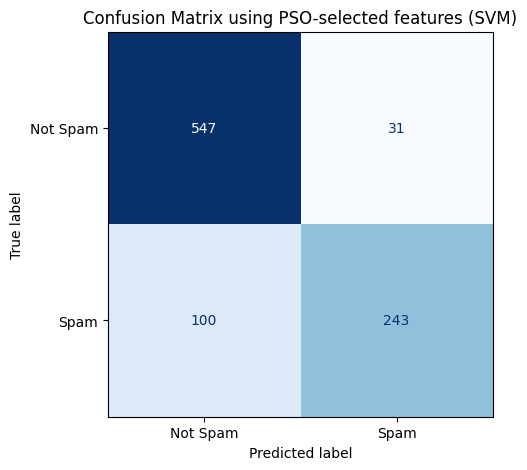


Evaluating KNN using PSO-selected features
Accuracy Score: 85.45 %

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.88      0.89      0.89       578
        Spam       0.81      0.79      0.80       343

    accuracy                           0.85       921
   macro avg       0.85      0.84      0.84       921
weighted avg       0.85      0.85      0.85       921



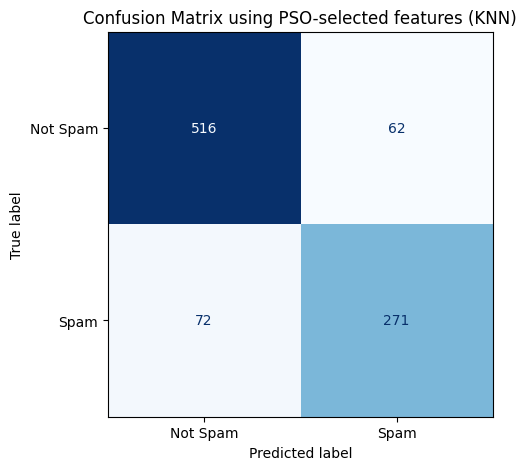


Evaluating Random Forest using PSO-selected features
Accuracy Score: 94.14 %

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.94      0.97      0.95       578
        Spam       0.94      0.90      0.92       343

    accuracy                           0.94       921
   macro avg       0.94      0.93      0.94       921
weighted avg       0.94      0.94      0.94       921



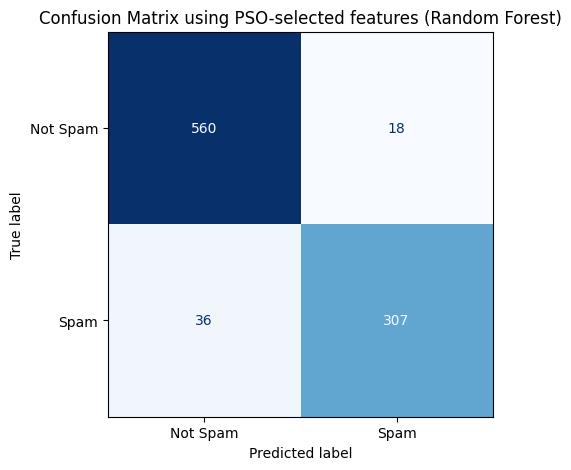

In [132]:
# Evaluate and visualize results for all models using PSO-selected features
for name, model in models.items():
    print(f"\n{'='*30}\nEvaluating {name} using PSO-selected features\n{'='*30}")

    # Train the model on PSO-selected features and predict on test set
    model.fit(X_train_pso, y_train)
    y_pred = model.predict(X_test_pso)

    # Calculate and print accuracy score
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy Score: {acc * 100:.2f} %")

    # Print detailed classification report with class names
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # Plot and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))

    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix using PSO-selected features ({name})")
    plt.show()


# **Evaluate & Compare Models Using Different Feature Sets**


SVM (All Features)
              precision    recall  f1-score   support

    Not Spam       0.89      0.95      0.92       578
        Spam       0.91      0.80      0.85       343

    accuracy                           0.90       921
   macro avg       0.90      0.88      0.89       921
weighted avg       0.90      0.90      0.89       921



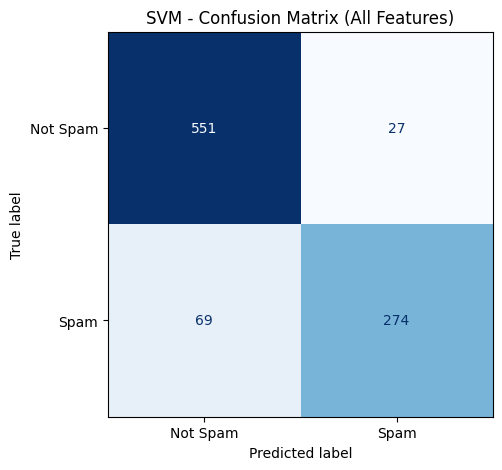


SVM (GA Selected)
              precision    recall  f1-score   support

    Not Spam       0.83      0.96      0.89       578
        Spam       0.90      0.68      0.77       343

    accuracy                           0.85       921
   macro avg       0.87      0.82      0.83       921
weighted avg       0.86      0.85      0.85       921



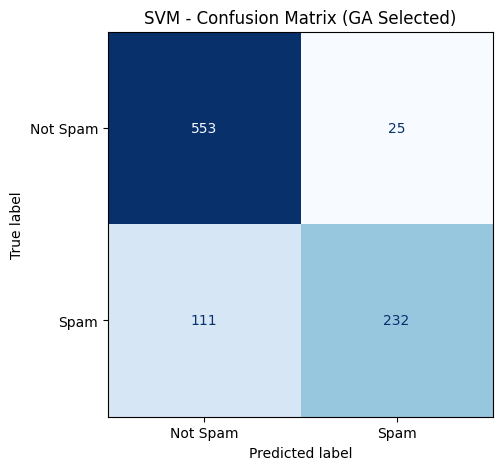


SVM (PSO Selected)
              precision    recall  f1-score   support

    Not Spam       0.85      0.95      0.89       578
        Spam       0.89      0.71      0.79       343

    accuracy                           0.86       921
   macro avg       0.87      0.83      0.84       921
weighted avg       0.86      0.86      0.85       921



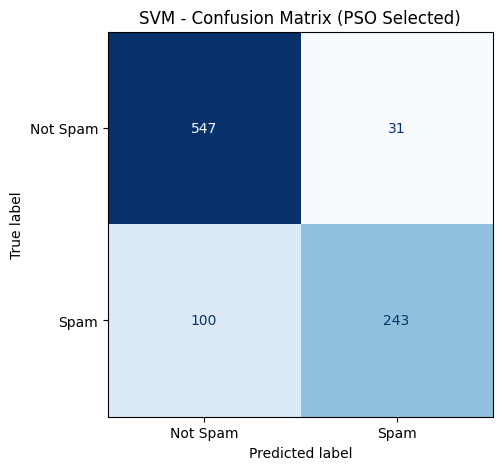


KNN (All Features)
              precision    recall  f1-score   support

    Not Spam       0.89      0.92      0.90       578
        Spam       0.86      0.80      0.83       343

    accuracy                           0.88       921
   macro avg       0.87      0.86      0.87       921
weighted avg       0.88      0.88      0.88       921



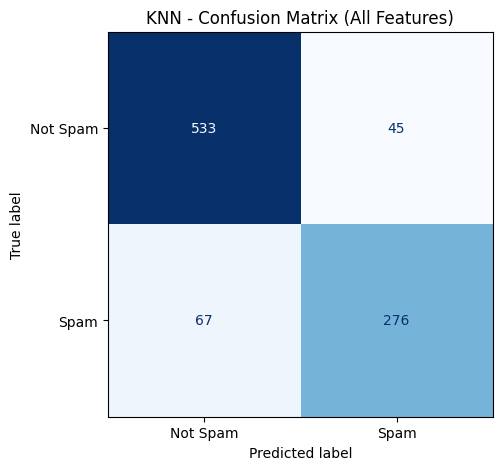


KNN (GA Selected)
              precision    recall  f1-score   support

    Not Spam       0.90      0.91      0.90       578
        Spam       0.84      0.83      0.84       343

    accuracy                           0.88       921
   macro avg       0.87      0.87      0.87       921
weighted avg       0.88      0.88      0.88       921



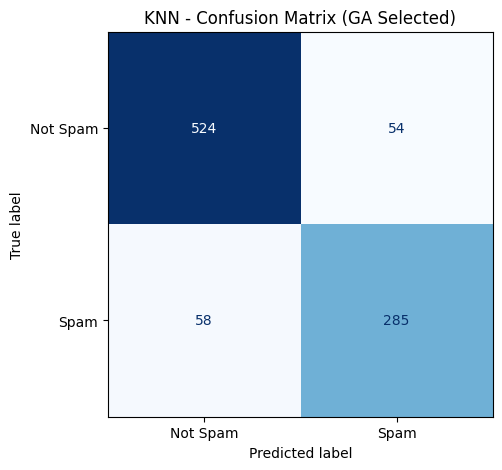


KNN (PSO Selected)
              precision    recall  f1-score   support

    Not Spam       0.88      0.89      0.89       578
        Spam       0.81      0.79      0.80       343

    accuracy                           0.85       921
   macro avg       0.85      0.84      0.84       921
weighted avg       0.85      0.85      0.85       921



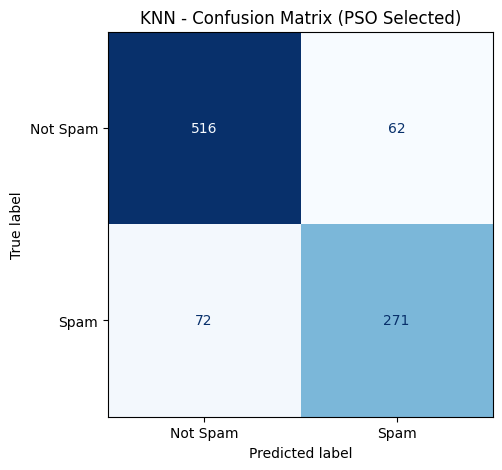


Random Forest (All Features)
              precision    recall  f1-score   support

    Not Spam       0.93      0.96      0.95       578
        Spam       0.94      0.89      0.91       343

    accuracy                           0.93       921
   macro avg       0.93      0.92      0.93       921
weighted avg       0.93      0.93      0.93       921



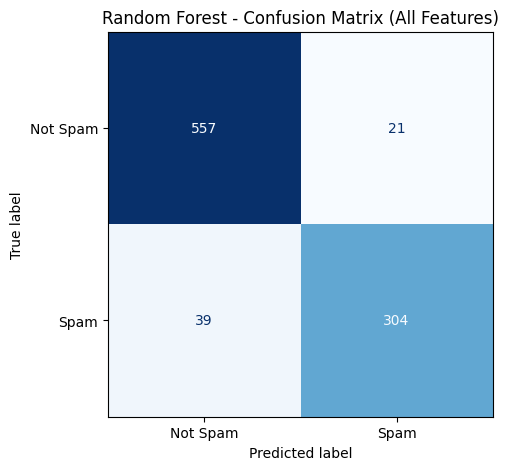


Random Forest (GA Selected)
              precision    recall  f1-score   support

    Not Spam       0.95      0.97      0.96       578
        Spam       0.95      0.92      0.93       343

    accuracy                           0.95       921
   macro avg       0.95      0.94      0.95       921
weighted avg       0.95      0.95      0.95       921



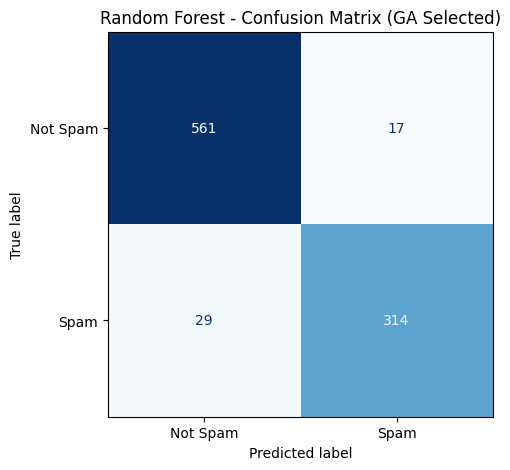


Random Forest (PSO Selected)
              precision    recall  f1-score   support

    Not Spam       0.94      0.97      0.95       578
        Spam       0.94      0.90      0.92       343

    accuracy                           0.94       921
   macro avg       0.94      0.93      0.94       921
weighted avg       0.94      0.94      0.94       921



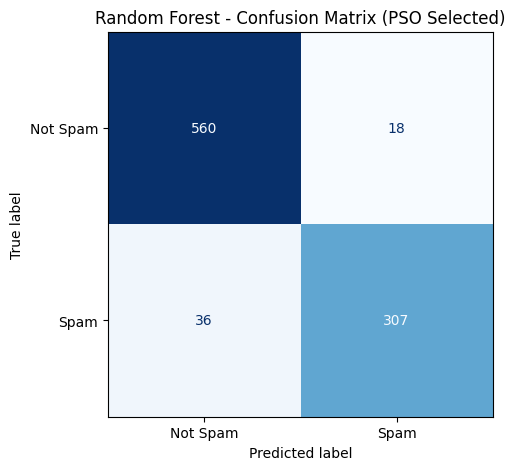


Model Comparison Table:
           Model   Feature_Set  Accuracy  Precision  Recall  F1_Score
0            SVM  All Features     0.896      0.910   0.799     0.851
1            SVM   GA Selected     0.852      0.903   0.676     0.773
2            SVM  PSO Selected     0.858      0.887   0.708     0.788
3            KNN  All Features     0.878      0.860   0.805     0.831
4            KNN   GA Selected     0.878      0.841   0.831     0.836
5            KNN  PSO Selected     0.855      0.814   0.790     0.802
6  Random Forest  All Features     0.935      0.935   0.886     0.910
7  Random Forest   GA Selected     0.950      0.949   0.915     0.932
8  Random Forest  PSO Selected     0.941      0.945   0.895     0.919


In [131]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize list to store evaluation results for comparison
comparison_data = []

# Helper function to evaluate a model on given data, collect metrics, and plot confusion matrix
def evaluate_and_collect(model, X_tr, X_te, label, name):
    model.fit(X_tr, y_train)              # Train model
    y_pred = model.predict(X_te)          # Predict on test set

    # Calculate metrics and add to comparison list
    metrics = {
        "Model": name,
        "Feature_Set": label,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1_Score": f1_score(y_test, y_pred)
    }
    comparison_data.append(metrics)

    # Display detailed classification report
    print(f"\n{name} ({label})")
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"{name} - Confusion Matrix ({label})")
    plt.show()

# Evaluate all models on all feature sets: All, GA-selected, and PSO-selected features
for name, model in models.items():
    evaluate_and_collect(model, X_train, X_test, "All Features", name)
    evaluate_and_collect(model, X_train_ga, X_test_ga, "GA Selected", name)
    evaluate_and_collect(model, X_train_pso, X_test_pso, "PSO Selected", name)

# Convert collected metrics to a DataFrame for easy comparison
results_df = pd.DataFrame(comparison_data)

print("\nModel Comparison Table:")
print(results_df.round(3))   # Rounded for readability


# **Model Performance Comparison Across Feature Selection Methods**


🔎 Final Model Performance Comparison:
           Model Feature_Set  Accuracy  Precision  Recall  F1_Score
0            SVM    Original     0.896      0.910   0.799     0.851
1            SVM          GA     0.852      0.903   0.676     0.773
2            SVM         PSO     0.858      0.887   0.708     0.788
3            KNN    Original     0.878      0.860   0.805     0.831
4            KNN          GA     0.878      0.841   0.831     0.836
5            KNN         PSO     0.855      0.814   0.790     0.802
6  Random Forest    Original     0.935      0.935   0.886     0.910
7  Random Forest          GA     0.950      0.949   0.915     0.932
8  Random Forest         PSO     0.941      0.945   0.895     0.919

📊 Impact of Feature Selection (GA and PSO) Compared to Original Features:

Model: SVM | Feature Selection: GA
  Accuracy: 0.852 (↓ Decrease, Δ = -0.043)
  Precision: 0.903 (↓ Decrease, Δ = -0.008)
  Recall: 0.676 (↓ Decrease, Δ = -0.122)
  F1_Score: 0.773 (↓ Decrease, Δ = -0.078)

<ipython-input-128-1c1ab2164275>:49: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


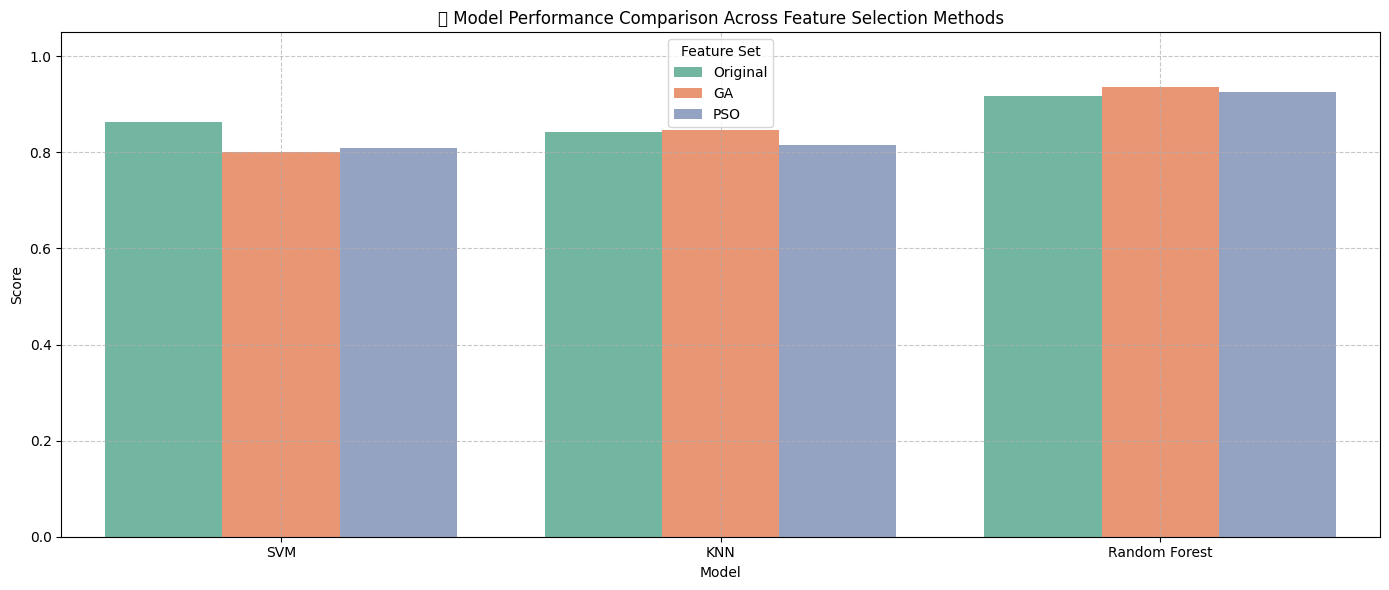

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame(comparison_data)

# Optional: Standardize Feature_Set names
results_df["Feature_Set"] = results_df["Feature_Set"].replace({
    "All Features": "Original",
    "GA Selected": "GA",
    "PSO Selected": "PSO"
})

print("\n🔎 Final Model Performance Comparison:")
print(results_df.round(3))

# === Assess the impact of GA and PSO ===
metrics = ["Accuracy", "Precision", "Recall", "F1_Score"]
baseline = results_df[results_df["Feature_Set"] == "Original"]

print("\n📊 Impact of Feature Selection (GA and PSO) Compared to Original Features:")
for method in ["GA", "PSO"]:
    fs_method = results_df[results_df["Feature_Set"] == method]
    for i, row in fs_method.iterrows():
        model_name = row["Model"]
        base_row = baseline[baseline["Model"] == model_name]
        if base_row.empty:
            continue
        print(f"\nModel: {model_name} | Feature Selection: {method}")
        for metric in metrics:
            change = row[metric] - base_row.iloc[0][metric]
            impact = "↑ Improvement" if change > 0 else ("↓ Decrease" if change < 0 else "→ No Change")
            print(f"  {metric}: {row[metric]:.3f} ({impact}, Δ = {change:+.3f})")

# === Visualization ===
results_melted = results_df.melt(
    id_vars=["Model", "Feature_Set"],
    value_vars=metrics,
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(14, 6))
sns.barplot(data=results_melted, x="Model", y="Score", hue="Feature_Set", errorbar=None, palette="Set2")
plt.title("📈 Model Performance Comparison Across Feature Selection Methods")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title="Feature Set")
plt.show()
